# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [25]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors  
import plotly.express as px

# Import API key
from api_keys import geoapify_key

In [27]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head(5)

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,constantia,44.1833,28.6500,11.50,88,92,6.38,RO,1733598634
1,1,hithadhoo,-0.6000,73.0833,27.79,73,18,5.63,MV,1733598823
2,2,carbonear,47.7332,-53.2148,1.00,79,100,6.22,CA,1733598824
3,3,waitangi,-43.9535,-176.5597,14.34,81,92,1.34,NZ,1733598507
4,4,yeppoon,-23.1333,150.7333,23.20,82,8,1.69,AU,1733598827


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [30]:
%%capture --no-display
# Create a color mapping for each city
unique_cities = city_data_df['City'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_cities))  

# Create a color mapping dictionary
color_mapping = {city: colors(i) for i, city in enumerate(unique_cities)}

# Convert RGBA colors to hex format for hvplot
color_mapping = {city: mcolors.rgb2hex(colors(i)[:3]) for i, city in enumerate(unique_cities)}

# Step 2: Add a new column to the DataFrame for colors
city_data_df['Color'] = city_data_df['City'].map(color_mapping)

#Configure the map plot with unique colors for each city
map_plot = city_data_df.hvplot.points(
    'Lng', 'Lat', 
    size='Humidity', 
    color='Color',  
    title='City Humidity Map',
    hover_cols=['City', 'Country'],
    legend='top_right',  
    xlabel='Longitude',  
    ylabel='Latitude'    
)


# Display the map
map_plot

:Points   [Lng,Lat]   (Color,Humidity,City,Country)

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [33]:
# Narrow down cities that fit criteria and drop any results with null values
# Ideal weather conditions
ideal_temp_min = 21  
ideal_temp_max = 27  
ideal_wind_speed = 4.5  
ideal_cloudiness = 0  

filtered_city_data_df = city_data_df[
    (city_data_df['Max Temp'] > ideal_temp_min) &
    (city_data_df['Max Temp'] < ideal_temp_max) &
    (city_data_df['Wind Speed'] < ideal_wind_speed) &
    (city_data_df['Cloudiness'] == ideal_cloudiness)  
]

filtered_city_data_df.insert(0, 'Order Number', range(1, len(filtered_city_data_df) + 1))

# Drop any rows with null values and column with color 
filtered_city_data_df = filtered_city_data_df.dropna()
filtered_city_data_df = filtered_city_data_df[['City_ID', 'City_ID', 'City', 'Lat', 'Lng', 'Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed', 'Country', 'Date']]

# Display sample data
filtered_city_data_df

,City_ID,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
16,16,16,hawaiian paradise park,19.5933,-154.9731,25.50,77,0,2.06,US,1733598517
87,87,87,wimauma,27.7125,-82.2990,21.03,63,0,1.34,US,1733598928
98,98,98,saint-pierre,-21.3393,55.4781,25.82,65,0,1.54,RE,1733598319
111,111,111,beaudesert,-27.9833,152.9833,22.08,23,0,0.23,AU,1733598955
122,122,122,callao,-12.0667,-77.1500,22.16,68,0,3.09,PE,1733598968
231,231,231,holualoa,19.6228,-155.9522,24.37,64,0,2.57,US,1733598511
232,232,232,brandon,27.9378,-82.2859,21.15,54,0,1.79,US,1733599046
243,243,243,piton saint-leu,-21.2196,55.3151,23.06,65,0,1.54,RE,1733599102
353,353,353,urangan,-25.3000,152.9000,25.09,72,0,4.35,AU,1733599240
357,357,357,lompoc,34.6391,-120.4579,25.01,29,0,1.54,US,1733599246


### Step 3: Create a new DataFrame called `hotel_df`.

In [36]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = filtered_city_data_df[['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df['Hotel Name'] = ''

# Display sample data
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel Name
16,hawaiian paradise park,US,19.5933,-154.9731,77,
87,wimauma,US,27.7125,-82.2990,63,
98,saint-pierre,RE,-21.3393,55.4781,65,
111,beaudesert,AU,-27.9833,152.9833,23,
122,callao,PE,-12.0667,-77.1500,68,
231,holualoa,US,19.6228,-155.9522,64,
232,brandon,US,27.9378,-82.2859,54,
243,piton saint-leu,RE,-21.2196,55.3151,65,
353,urangan,AU,-25.3000,152.9000,72,
357,lompoc,US,34.6391,-120.4579,29,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [39]:
# Set parameters to search for a hotel
radius = 10000
params = {
    "categories": "hotel,motel,inn",
    "apiKey": geoapify_key,  
    "limit": 1, 
}

#  Print a message to follow up the hotel search
print("Starting hotel search using the Geoapify API...")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # Get latitude and longitude from the DataFrame
    latitude = row['Lat']
    longitude = row['Lng']
    
    # Add the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"  
    params["bias"] = f"proximity:{longitude},{latitude}"

    # Set base URL
    base_url = "https://maps.geoapify.com/v1/tile/carto/{z}/{x}/{y}.png?&apiKey=8d01bd6a9acd4b36ad6cdb254587d94d"

    # Make and API request using the params dictionary
    name_address_response = requests.get(base_url, params=params)

    # Convert the API response to JSON format
    name_address = name_address_response.json()

    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
    
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df


Starting hotel search using the Geoapify API...
hawaiian paradise park - nearest hotel: No hotel found
wimauma - nearest hotel: No hotel found
saint-pierre - nearest hotel: No hotel found
beaudesert - nearest hotel: No hotel found
callao - nearest hotel: No hotel found
holualoa - nearest hotel: No hotel found
brandon - nearest hotel: No hotel found
piton saint-leu - nearest hotel: No hotel found
urangan - nearest hotel: No hotel found
lompoc - nearest hotel: No hotel found
hilo - nearest hotel: No hotel found
tolanaro - nearest hotel: No hotel found
parkes - nearest hotel: No hotel found
tsaratanana - nearest hotel: No hotel found
tsiombe - nearest hotel: No hotel found


,City,Country,Lat,Lng,Humidity,Hotel Name
16,hawaiian paradise park,US,19.5933,-154.9731,77,No hotel found
87,wimauma,US,27.7125,-82.2990,63,No hotel found
98,saint-pierre,RE,-21.3393,55.4781,65,No hotel found
111,beaudesert,AU,-27.9833,152.9833,23,No hotel found
122,callao,PE,-12.0667,-77.1500,68,No hotel found
231,holualoa,US,19.6228,-155.9522,64,No hotel found
232,brandon,US,27.9378,-82.2859,54,No hotel found
243,piton saint-leu,RE,-21.2196,55.3151,65,No hotel found
353,urangan,AU,-25.3000,152.9000,72,No hotel found
357,lompoc,US,34.6391,-120.4579,29,No hotel found


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

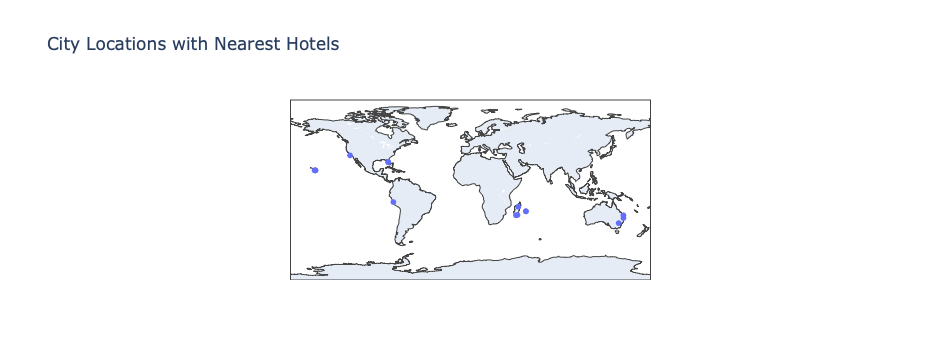

In [41]:
%%capture --no-display

# Configure the map plot
fig = px.scatter_geo(
    filtered_city_data_df,
    lat='Lat',
    lon='Lng',
    hover_name='City',
    hover_data={
        'Country': True,  
        'Hotel Name': hotel_df['Hotel Name'], 
        'Max Temp': True,  
        'Humidity': True,   
    },
    title='City Locations with Nearest Hotels',
    template='plotly',
)


# Display the map
fig.show()